## Types of single-nucleotide polymorphism 

In a population of chromosomes (two for each individual in a cohort), 
a variety of alleles may be segregating at any given site. 
For example, the reference allele may be "C", 
but some chromosomes may harbor "A" as an ALT allele, and yet others may harbor "T" as a second ALT allele. 

There are eight possible categories to which a given site may belong (considering only single-nucleotide alleles):
one representing the case that a site is monomorphic (no ALT allele);
three representing the case where one ALT allele is segregating (there are three possible ALT alleles for each REF allele),
three representing the case where two ALT alleles are segregating (there are three possible ways to pair each of the three possible ALT alleles), 
one representing the case where all three possible ALT alleles are found in the population. 

A concrete description of these scenarios is presented in the following table, 
which corresponds to a REF allele of "C": 

$$ 
\begin{array}{ccccc}
A & G & T & \#ALTs & probabilities \\ 
\hline 
  &   &   & 0 & p_{C \rightarrow \{C\}} \\
* &   &   & 1 & p_{C \rightarrow \{A\}} \\
  & * &   & 1 & p_{C \rightarrow \{G\}} \\
  &   & * & 1 & p_{C \rightarrow \{T\}} \\
* & * &   & 2 & p_{C \rightarrow \{A,G\}} \\
* &   & * & 2 & p_{C \rightarrow \{A,T\}} \\
  & * & * & 2 & p_{C \rightarrow \{G,T\}} \\
* & * & * & 3 & p_{C \rightarrow \{A,G,T\}} \\
\end{array} 
$$

Note that the substitution probabilities indicated in the table relate to the 
presence or absence of polymorphism, not to the rate at which mutations occur. 
For example, $p_{C \rightarrow \{A\}}$ 
should be interpreted to be the probability
that a randomly chosen site at which the reference nucleotide is C 
would harbor an A allele in one or more chromosomes from a given cohort. 
(We do not care whether the A allele appears as a heterozygote or homozygote in any given individual 
from the cohort.)
$p_{C \rightarrow \{A\}}$ should not be equated with the probability that C mutates to A, 
as, for example, such a mutation could have happened many times in independent ancestors of the cohort 
without impacting the site's classification as being polymorphic or not in the cohort. 

Though double-ALT probabilities, e.g., $p_{C \rightarrow \{G,T\}}$, may depend upon single-ALT probabilities, e.g., $p_{C \rightarrow \{G\}}$ and $p_{C \rightarrow \{T\}}$, we make no attempt to model the dependence, in part because there are so many ways in which multiple ALT alleles could end up segregating at a site. (For example, if C, G and T alleles are segregating, then did the C allele mutate to the G allele, which then subsequently mutated to the T allele, or did the G and T alleles each arise by mutation of C?) Instead we simply estimate the probability of observing multiple ALT alleles segregating at a site. 








## Sequence-dependent polymorphism

It is now well-established that the substitution probabilities mentioned above depend not only on the identity of the base in the reference genome at the polymorphic site, but also the bases in the reference genome that surround the polymorphic site [Halldorsson et al 2021; Li et al 2021; Feng, Deng, Li 2021; Iulio et al 2018, Aggarwala and Voight 2016; Samocha et al 2014]. To account for this,
we replace, for example, $p_{C \rightarrow \{A, T\}}$ by $p_{s \rightarrow \{A, T\}}$, where $s$ is a kmer whose center nucleotide is "C" in this example. 

Modelling the dependence of substituion probability on the local sequence context enables us to capture 
the dependence of mutation rate/mechanisms on local sequence context. For example, if the effect of recurrent mutation at CpG sites 
[Agarwal and Przeworski 2021] 
is to increase the fraction of CpG sites that are polymorphic, 
then estimates of the substitution probabilities in the model will be higher for CpG kmers, 
and that will carry forward to the predictions that the model makes in test regions. 




## How to estimate substitution probabilities 

Consider the polymorphism $s \rightarrow S$, where the reference kmer is $s = AGCGT$ and 
the new identities of the center nucleotide of $s$ is $S = \{A,T\}$. 
This represents the substituion events from the point of view of just one DNA strand. 
The actual double-stranded kmers before and after the change are depicted in the first row of the following image: 



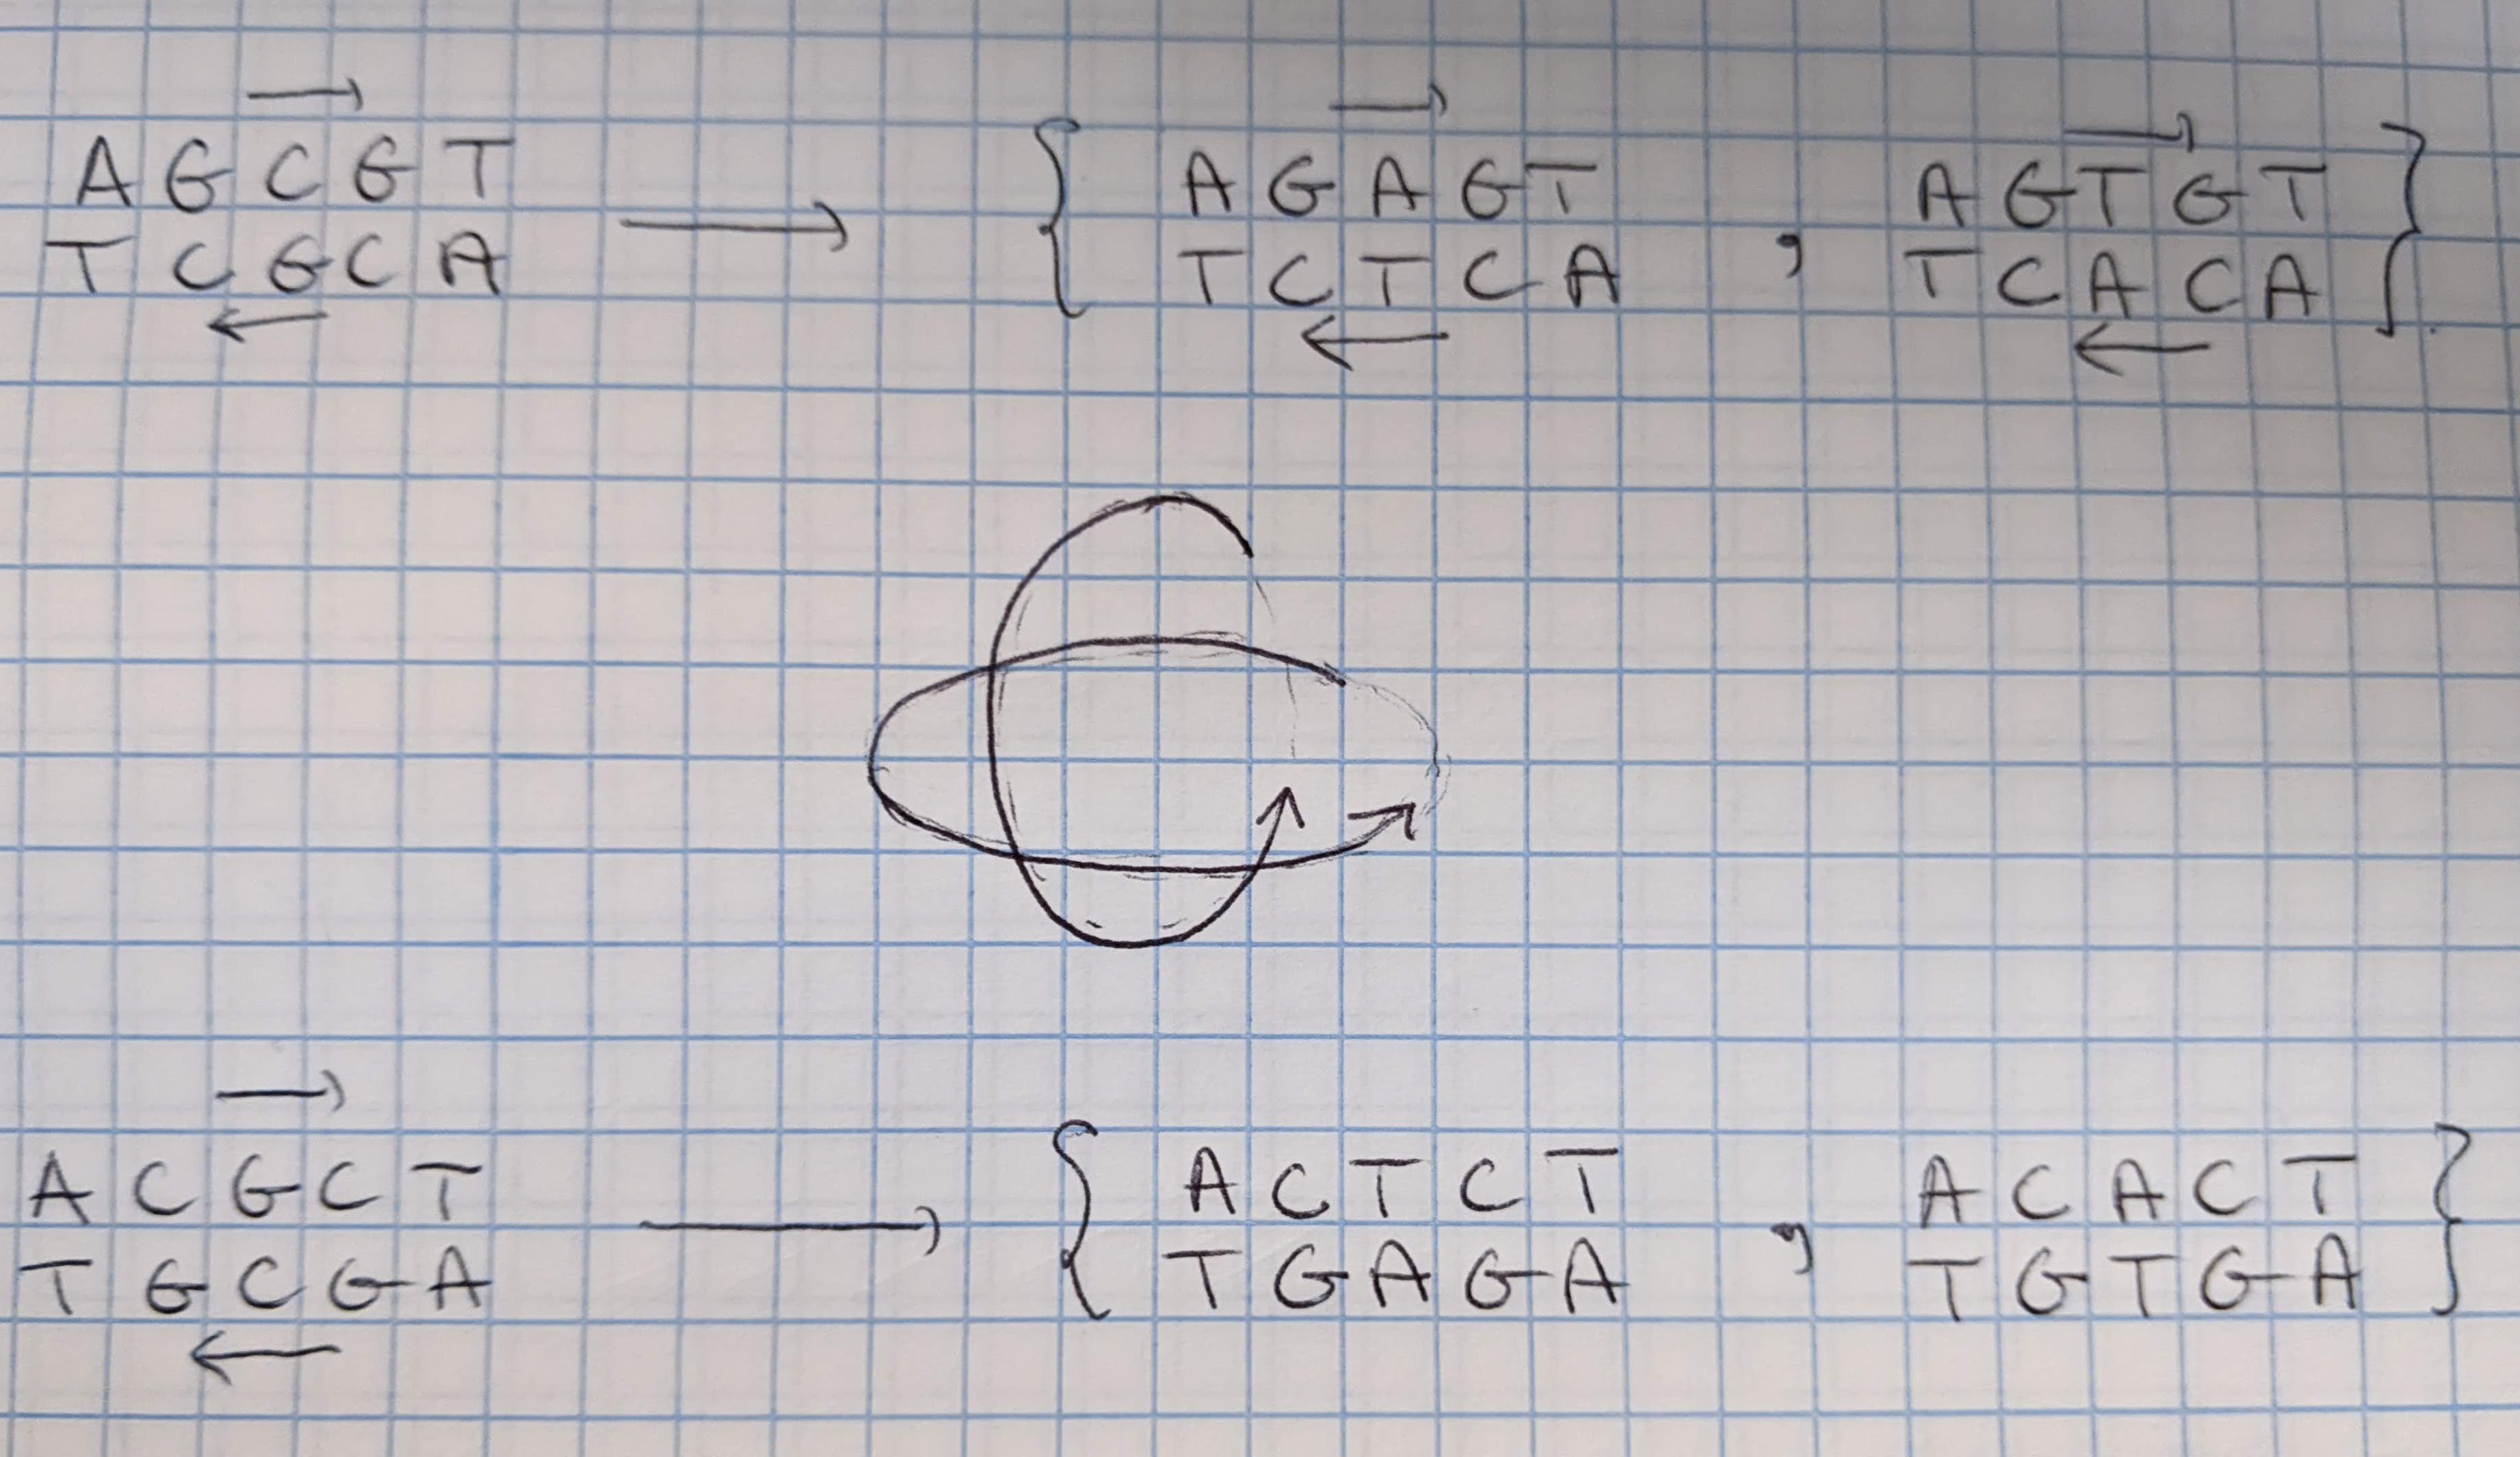

In [4]:
# embed raw image data in notebook: 
# https://github.com/microsoft/vscode-jupyter/issues/6437
from IPython.display import Image
Image(filename='PXL_20220315_230848012.jpg', width=600)

The second row shows the same DNA molecules that are depicted in the first row, 
but rotated through 180 degress about two orthogonal axes. 
The substitution events in the second row would be represented 
as $\overline{s} \rightarrow \overline{S}$, 
where $\overline{s} = ACGCT$ is the reverse complement of the kmer $s$
and $\overline{S} = \{ A, T \}$ is the complement of the set $S$. 
Since the orientation of the double-stranded DNA molecule is irrelevant to its 
probability of being polymorphic, 
we have that: 

$$
p_{s \rightarrow S} = p_{\overline{s} \rightarrow \overline{S}},
$$

which are in turn equal to the substitution probability of the double-stranded DNA molecule,
which, by [Maximum Likelihood Estimation](https://math.stackexchange.com/questions/421105/maximum-likelihood-estimator-of-parameters-of-multinomial-distribution/421838#421838), is: 

$$
\frac{\#(s \rightarrow S) + \#(\overline{s} \rightarrow \overline{S})}
{\#(s) + \#(\overline{s})}.
$$

Here, for example, $\#(s)$ is the number of reference-genome occurrences of the kmer $s$,
of which $\#(s \rightarrow S)$ of them are observed to be segregating the 
alleles $S$ in the cohort of interest. 






An example makes the point. Suppose there are 90 examples of $s= AGCGT$, 
of which 45 are polymorphic at the center nucleotide with ALT alleles $S = \{ A, T\}$. 
Further, suppose there are 10 examples of $\overline{s} = ACGCT$, 
of which 5 are polymorphic at the center nucleotide with the same segregating ALT alleles. 
Then 

\begin{align*}
\hat{p}_{s \rightarrow S} & =  \frac{45}{90} \\
\hat{p}_{\overline{s} \rightarrow \overline{S}} & =  \frac{5}{10} \\
\end{align*}

and both of those probabilites are equal to 

$$
\frac{45 + 5}{90 + 10},
$$

which is the estimate of the probability that the associated double-stranded kmer is substituted. 
Though all probability estimates are equal in this example, 
in general they will not be. 
Since the latter estimate involves the largest counts, and is therefore the most robust estimate, 
we will always estimate the common probabilities using merged counts from reverse complemented sequences. 


Since the single-stranded substitution probabilities occur in equal pairs, 
there are $4^5 . 7 / 2$ independent probabilities to be estimated. 
This number can be rewritten as $4^2.2.7.4^2$, 
showing that we may classify substitution probabilities using 
just two nucleotides in the center position of a 5-mer. 
In the following, we choose the nucleotides A and C. 

## A model to predict the number of ALT alleles in a genomic interval

Let $N_i$ be a Categorical Random Variable representing the number of distinct ALT alleles at the site (genomic position) $i$, with local sequence context $s_i$.
If the center nucleodtide of $s_i$ is C, then the allowed values of $N_i$, and their corresponding probabilities are: 

$$ 
N_i = 
\left\{
\begin{array}{ll}
0 & p_i^{(0)} = p_{s_i \rightarrow \{C\}} \\
1 & p_i^{(1)} = p_{s_i \rightarrow \{A\}} + p_{s_i \rightarrow \{G\}} + p_{s_i \rightarrow \{T\}} \\
2 & p_i^{(2)} = p_{s_i \rightarrow \{A,G\}} + p_{s_i \rightarrow \{A,T\}} + p_{s_i \rightarrow \{G,T\}} \\ 
3 & p_i^{(3)} = p_{s_i \rightarrow \{A,G,T\}}
\end{array}
\right.
$$ 

In an interval containing $l$ sites, there are $l$ "trials" of an experiment with four possible outcomes (the possible values of $N_i$ at each site). Though the exact probability distribution of the number of occurrences of each outcome aggregated over $l$ trials is known ([Beaulieu 1991](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=76452&tag=1)), 
it is not immediately useful to us, as we are interested in a derived quantity, the number of ALT alleles in the interval:

\begin{equation*}
N = \sum_{i=1}^l N_i.
\end{equation*}

Though it is cumbersome to derive a formula for this distribution (starting from Beaulieu's result), and computationally inefficient to 
simulate the distribution on a genome-wide scale, 
we can make headway with the first two moments of the distribution 
since they are easy to compute. 

Consider the first two moments of $N_i$: 

$$ 
\begin{align*}
\langle N_i \rangle & = 0p_i^{(0)} + 1p_i^{(1)} + 2p_i^{(2)} + 3p_i^{(3)} \\
\langle N_i^2 \rangle & = 0^2p_i^{(0)} + 1^2p_i^{(1)} + 2^2p_i^{(2)} + 3^2p_i^{(3)} \\
\end{align*}
$$ 

From these we may compute the mean of $N$: 

$$ 
\begin{align*}
\langle N \rangle & = \sum_{i=1}^l \langle N_i \rangle 
\end{align*}
$$ 

and the variance of $N$,
assuming that the number of ALT alleles at nearby sites are not correlated with one another: 

$$ 
\begin{align*}
\text{var}(N) & = \sum_{i=1}^l \text{var}(N_i) & \text{(assumes independence)} \\
& = \sum_{i=1}^l \left( \langle N_i^2 \rangle - \langle N_i \rangle^2 \right)
\end{align*}
$$ 

Note that $\langle N \rangle$ and $\text{var}(N)$ depend upon the sequence of the interval they correspond to. 

It is worth noting that we have defined $N$ to be the number of distinct ALT alleles 
at polymorphic sites *irrespective* of the number of individuals 
who were confidently genotyped at those sites (or the monomorphic sites, for that matter). 
We do this for two reasons: 
(1) this leads to larger counts (and therefore better signal-to-noise ratio) 
than would be obtained had 
we filtered polymorphic sites on the number of genotyped individuals 
and (2) the model uses *all* sites in a genomic interval 
to compute null expectations, but the number of genotyped 
individuals in gnomad version 3 is reported only for polymorphic sites. 

Note that the math described above applies even if the $l$ sites are not contiguous. Therefore, 
if an interval contains 100 sites, but kmers are known at only 90 of those sites 
(e.g., because some sites are "N" in the reference genome), 
then $l = 90$ and the code should filter out the 10 sites 
at which the local sequence context is unknown. 





## Detecting anomalous ALT allele counts

When the substitution probabilities $\{ p_{s_i \rightarrow S} \}$ are estimated using putatively neutral sites, the mean and variance 
computed above, representing the number of ALT alleles in a given genomic interval, 
are the expected numbers under the assumption of neutrality, 
conditioned upon the sequence context of the interval 
(which would otherwise confound the analysis). 
Therefore when the test statistic 

$$ 
\overline{N} = \frac{N - \langle N \rangle}{\sqrt{\text{var}(N)}}
$$

is much greater than one (e.g., $\overline{N} = 2$ would be a "2-$\sigma$ event" ), we reject the null model in favor of positive selection. Conversely, if $\overline{N}$ is much less than -1 (e.g., $\overline{N} = -2$ would also be a "2-$\sigma$ event" ), then we reject the null model in favor of negative selection. 

Put another way, by shifting and normalizing $N$ as shown above, we may gauge where $N$ lies on its null distribution, 
without actually computing that distribution, thereby gauging how unexpected the observed value of $N$ is. 



mean: exact = 4.234749385887466 ; simulated = 4.1866
variance: exact = 6.627148274600648 ; simulated = 6.665980440000001


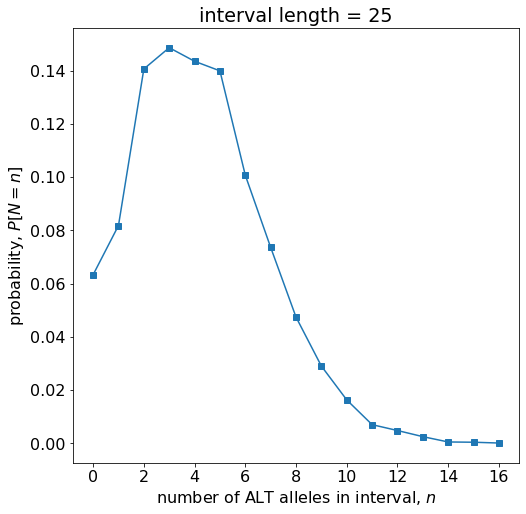

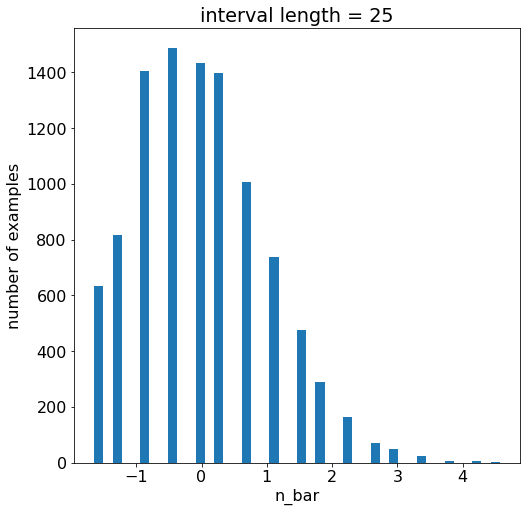

In [4]:
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt 
%matplotlib inline 

def plot_N(number_sites):
  # https://numpy.org/doc/stable/reference/random/generated/numpy.random.dirichlet.html
  p0s_p1s_p2s_p3s = np.random.dirichlet((10, 0.5, 0.5, 0.1), number_sites)

  # compute mean
  mean_Ns = np.array([0*p0 + 1*p1 + 2*p2 + 3*p3 for p0, p1, p2, p3 in p0s_p1s_p2s_p3s])
  mean_N_exact = np.sum(mean_Ns)

  # compute variance
  mean_N2s = np.array([(0**2)*p0 + (1**2)*p1 + (2**2)*p2 + (3**2)*p3 for p0, p1, p2, p3 in p0s_p1s_p2s_p3s])
  variance_N_exact = np.sum(mean_N2s - np.square(mean_Ns))

  N = []
  number_examples = 10000
  for example in range(number_examples):
    Ns = [np.random.choice(a=[0, 1, 2, 3], p=p0_p1_p2_p3) for p0_p1_p2_p3 in p0s_p1s_p2s_p3s]
    N.append(np.sum(Ns))

  print(f'mean: exact = {mean_N_exact} ; simulated = {np.mean(N)}') 
  print(f'variance: exact = {variance_N_exact} ; simulated = {np.var(N)}') 

  N_histogram = Counter(N)    
  max_N = max(N)
  x_N = range(max_N+1)
  probability_of_N = np.array([
      N_histogram[value] 
      if value in N_histogram 
      else 0 
      for value in x_N
  ])/number_examples

  plt.figure(figsize=(8,8))
  plt.rcParams.update({'font.size': 16})    
  plt.plot(x_N, probability_of_N, marker='s')
  plt.title(f'interval length = {number_sites}')
  plt.xlabel(f'number of ALT alleles in interval, $n$')
  _ = plt.ylabel('probability, $P[N=n]$')

  N = np.array(N)
  Nbar = (N - mean_N_exact)/np.sqrt(variance_N_exact)

  plt.figure(figsize=(8,8))
  plt.rcParams.update({'font.size': 16})    
  _ = plt.hist(Nbar, bins='auto')
  plt.title(f'interval length = {number_sites}')
  plt.xlabel(f'n_bar')
  _ = plt.ylabel('number of examples')

plot_N(number_sites=25)

mean: exact = 17.35645178795186 ; simulated = 17.3062
variance: exact = 30.495963910670046 ; simulated = 30.619241560000003


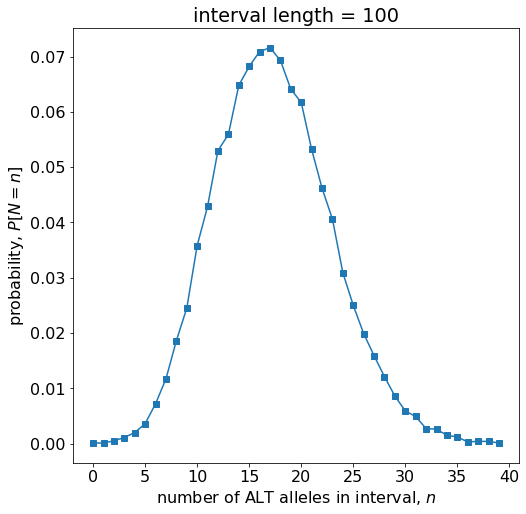

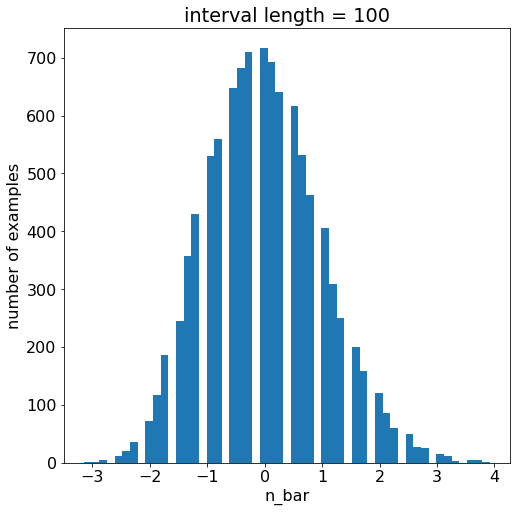

In [41]:
plot_N(number_sites=100)

mean: exact = 34.1819490825782 ; simulated = 34.125
variance: exact = 53.21097412589779 ; simulated = 54.798575


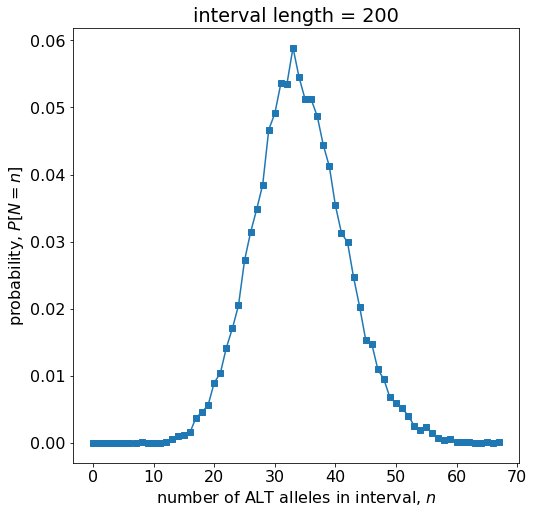

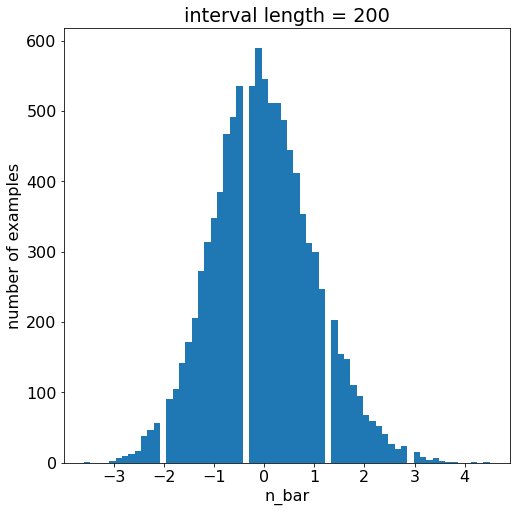

In [48]:
plot_N(number_sites=200)

## Models to predict the number of singleton ALT alleles in a genomic interval

Consider the following data taken from version 3 of the gnomad browser (https://gnomad.broadinstitute.org/) concerning a polymorphic site: 

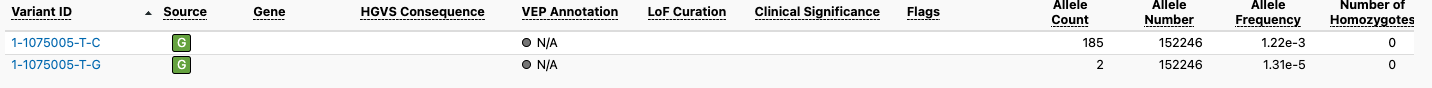

In [36]:
# embed raw image data in notebook: 
# https://github.com/microsoft/vscode-jupyter/issues/6437
from IPython.display import Image
Image(filename='gnomad-allele-frequencies.png', width=2000)

These data tell us that, at site chr1:1,075,005, there are three segregating alleles: T, C and G. Using the notation introduced earlier, this site is classified as $T \rightarrow \{ C, G \}$.

If we imagine "breaking apart" all the genotypes that were confidently called at this site, 
and pooling the resulting 152,246 chromosomes, then 185 of those chromosomes harbor the C allele, and 2 of them harbor the G allele. The remaining chromosomes harbor the T allele. (Note that we cannot know, based upon these data alone, how many of each of the possible diploid genotypes (T/T, T/C, T/G, G/C) exist in the cohort.)

Since natural selection ultimately acts upon alleles, not sites, we may attempt to use ALT allele frequencies to infer natural selection, 
in addition to the model of ALT allele count described in previous sections. For example, when the number of ALT alleles in a 100bp interval, say, is smaller than the number expected given the sequence that appears in those 100bp, one *might* suspect that purifing selection has been acting. If, in addition, the frequencies of the ALT alleles at those sites are smaller, in some sense, than an expectation derived from putatively neutral regions, then one's confidence in rejecting the neutral hypothesis is increased. 




As a first pass at developing expectations regarding allele frequencies, 
we collect a large sample of putatively neutral intervals of size equal to the size, $l$, of a test interval. 
(We'll explain later why the training and test intervals must be size-matched.) 
We then stratify by $M$ ($\leq N$): the number of ALT alleles in the interval at sites that have been genotyped in a threshold number of chromosomes. 
For example, a stratum may consist of all intervals with $M=3$ ALT alleles observed at sites where at least 
100,000 chromosomes have been genotyped. (Note that we do not need to filter out SNVs where the corresponding kmer is 
not completely specified in the reference genome, e.g., the kmer contains an "N".)

Imposing a cutoff on the number of chromosomes enables us to reliably estimate the number of singletons at those sites. 
To see this, suppose that the number of individuals in the cohort is 70,000, so that the number of chromosomes is 140,000. 
Then, if 1 out of 100,000 genotyped chromosomes harbors the A allele, then the probability that the A allele is also a singleton in the 
population of 140,000 chromosomes is the same as the probability that the 40,000 chromosomes that were not genotyped at this site 
actually harbor a non-A allele, which is estimated to be $(1 - 1/100000)^{40000} \approx 0.68$. In other words, 
given that an SNV is a singleton when observed as such in 100,000 chromosomes, 
it is most likely still a singleton among all 140,000 available chromosomes. 

We note that filtering on chromosome number originates in a model that assumes that allele frequencies at neighboring sites are 
independent, which is likely to be a poor assumption given that sites are no further apart 
than $l=50$ bp, say. 
To see why the model ignores dependencies among sites, 
consider three consecutive sites, with allele frequencies 1/100,000, 1/1,000 and 1/100,000. 
Under a model of independent sites, 
we would predict with practical certainty (the probability is actually $1 - (1 - 1/1000)^{(140000-1000)}$) 
that the center site is not a singleton in the full set of 140,000 chromosomes. 
However, under a model of dependent sites, 
with strong enough correlations between sites,
we might draw the opposite conclusion (the center site is a singleton among 140,000 chromosomes), 
given that the neighboring sites are most likely singletons
(as computed above). 
In other words, under the dependent-sites model, 
the fact that an incredibly rare ALT allele was observed at the center site after only 
1,000 "trials" is considered to be just "dumb luck". 
This example also underscores the folly of attempting to include polymorphic sites 
that have been genotyped at only a few chromosomes by 
predicting whether the ALT allele is 
a singleton among 140,000 chromosomes: to do so, we need to model allele frequency correlations, 
about which we know very little. 

Let's denote by $K$ the number of ALT alleles that are singletons in a given interval. 
By considering many intervals, each harboring $M$ ALT alleles, 
and each of size $l$, 
we may form an empirical distribution of $K$, 
conditioned on $M$ and $l$,
thereby yielding estimations of $\langle K \, | \, M = m , \,l\rangle$ and $\text{var} (K \, | \, M = m , \, l)$. 

Thus, although the chromosome-number filter was motivated by an unrealistic model of independent sites, 
the empirical distributions we end up computing *does not* 
assume indpendent sites, as it captures allele frequency correlations among the sites that survive filtering. 
Of course, in the testing phase, we must apply the same filter on chromosome number. 








## The necessity of conditioning singleton count on ALT-allele count and interval length

The conditioning of singleton count, $K$, on ALT allele number, $M$, is important as, under a simple population-genetics model, we expect 
$$
K \, | \, M = m \sim \text{Binomial} (m, p)
$$

where $m$ is the number of ALT alleles in the stratum, and $p$ is the probability that a random ALT allele is a singleton under neutrality ([see here](https://docs.google.com/presentation/d/11jOQA2BSNMa10xb5lSksZDqiiyCr8Kgl6cDOCAFSFGA/edit?usp=sharing)). 
Similar dependences of $K$ on $M$ are expected under models that 
don't assume SNVs are independent. 



The restriction to training intervals of length equal to the test-interval length, $l$, is important 
because it accounts for a potentially confounding variable: 
the degree to which the allele frequencies of neighboring SNVs are correlated. 
A concrete example makes the point: 

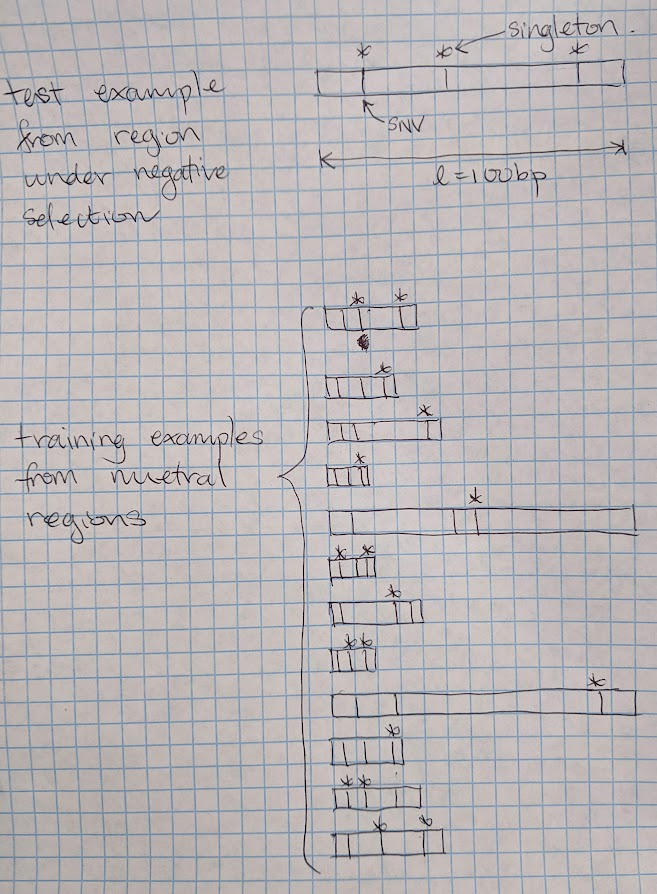

In [12]:
Image(filename='how-to-choose-training-examples-for-singleton-null-model.jpg', width=300)

Since the test interval in this illustration 
is under negative selection, there are fewer ALT alleles than you'd expect for a neutral region of the same size, 
which is supported by the fact that neutral regions that have as few ALT alleles as the test interval 
are generally much shorter than the test interval. 
However, we cannot use the typical neutral interval harboring 3 ALT alleles to form an expectation about 
allele frequencies because SNVs in such intervals are typically much closer to one another 
than the SNVs in the test interval, 
implying that allele-frequencies of neighboring SNVs are more correlated in such intervals 
than they are in the test interval. 
In the illustration, we would account for this confounding variable by 
forming a training set from only the two 100bp neutral intervals (with 3 SNVs). 

The drawback of this strategy is that, in the training phase, we must anticipate the size of the 
intervals that will be used in the test phase. This can be addressed in two ways. 

First, we can generate null models of singleton counts for a handful of interval lengths, 
and then force users to use only those interval lengths.  

Second, we can build ML models that map the tuples $(l, m)$ of interval lengths, $l$, 
and ALT-allele counts, $m$, in neutral regions to $p(k)$, 
the distribution of singleton count, e.g.:


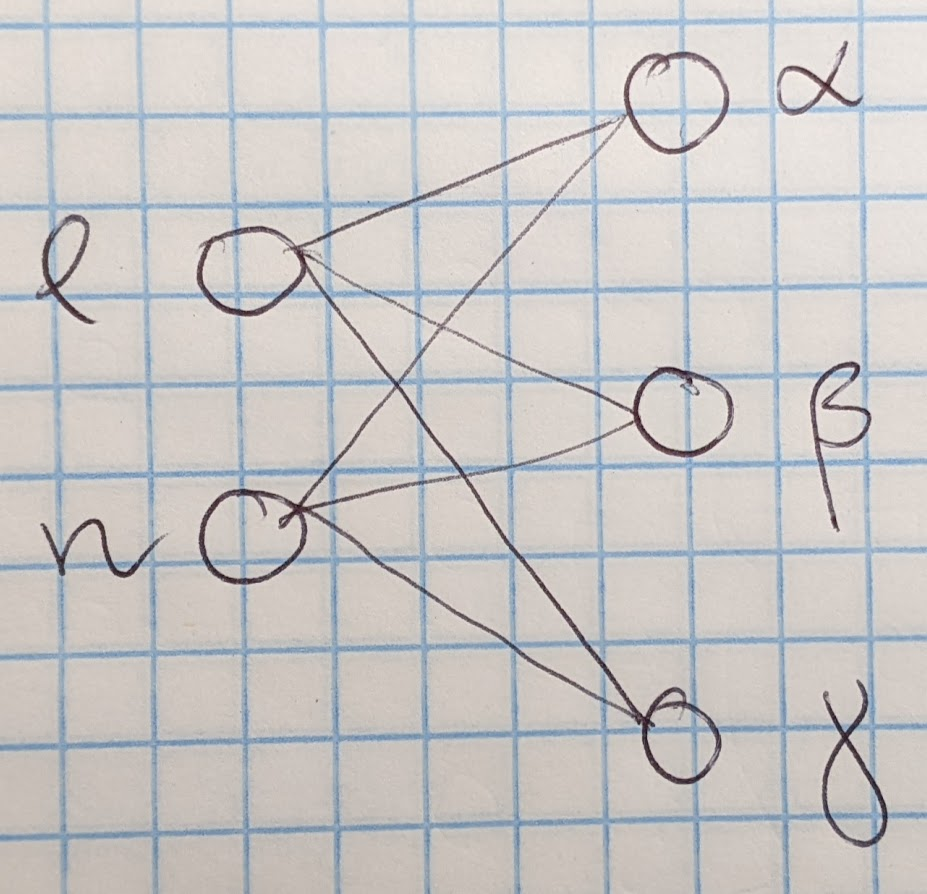

In [10]:
Image(filename='ml-model-of-singleton-number.jpg', width=200)

The advantage of this approach is two fold: we could use all neutral regions, 
regardless of their length, 
*and* we would not need to anticipate 
the size of the interval chosen by the user at test time. 

Since the first approach (restricting the training interval sizes) is the simplest, 
we employed it to develop the prototype of our software tool.

## Detecting anomalous singleton-allele counts

We control for the confounding effects of ALT count $M$ and interval length $l$ on the distribution of singleton count $K$ using a similar approach to how we corrected for the effect of sequence on ALT count: we shift and scale the singleton number: 

$$ 
\overline{K} = \frac{K - \langle K \,|\, M = m, \, l\rangle }{\sqrt{\text{var}(K \, | \, M = m, \, l)}}. 
$$

When $\overline{K}$ is much greater than 1 or much less than -1, we reject the null model in favor of negative or positive selection, respectively. 



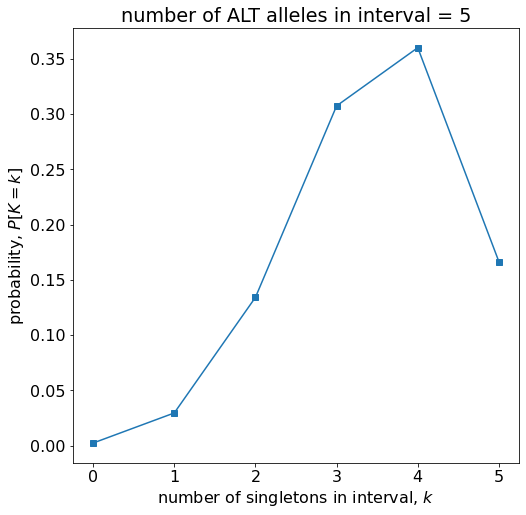

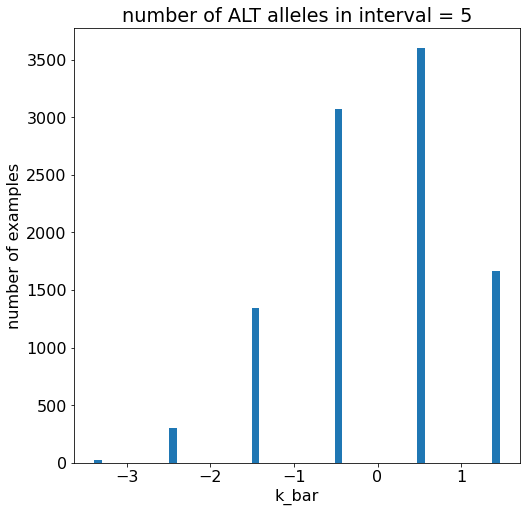

In [6]:
def plot_K(m): # m = number of ALT alleles in interval 
  p = 0.7 # genome-wide singleton fraction 
  number_examples = 10000
  K = np.random.binomial(m, p, number_examples)

  K_histogram = Counter(K)    
  max_K = max(K)
  x_K = range(max_K+1)
  probability_of_K = np.array([
      K_histogram[value] 
      if value in K_histogram 
      else 0 
      for value in x_K
  ])/number_examples

  plt.figure(figsize=(8,8))
  plt.rcParams.update({'font.size': 16})    
  plt.plot(x_K, probability_of_K, marker='s')
  plt.title(f'number of ALT alleles in interval = {m}')
  plt.xlabel(f'number of singletons in interval, $k$')
  _ = plt.ylabel('probability, $P[K=k]$')

  K = np.array(K)
  Kbar = (K - np.mean(K))/np.sqrt(np.var(K))

  plt.figure(figsize=(8,8))
  plt.rcParams.update({'font.size': 16})    
  _ = plt.hist(Kbar, bins='auto')
  plt.title(f'number of ALT alleles in interval = {m}')
  plt.xlabel(f'k_bar')
  _ = plt.ylabel('number of examples')

plot_K(m=5)


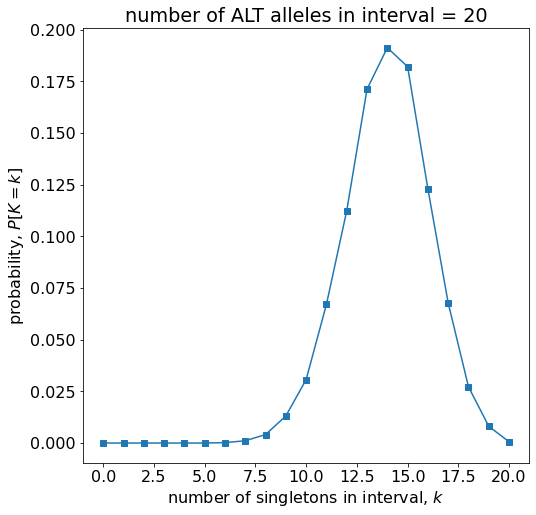

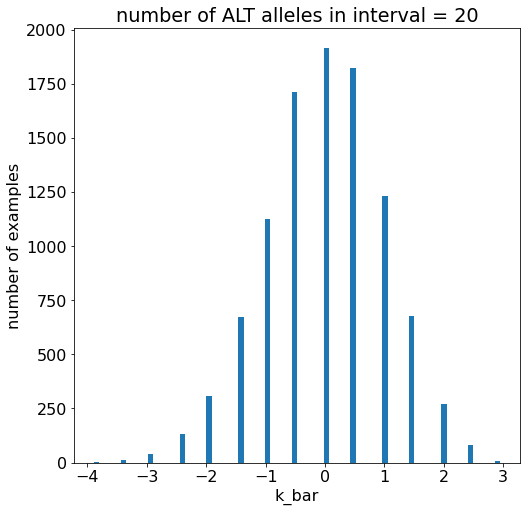

In [7]:
plot_K(m=20)

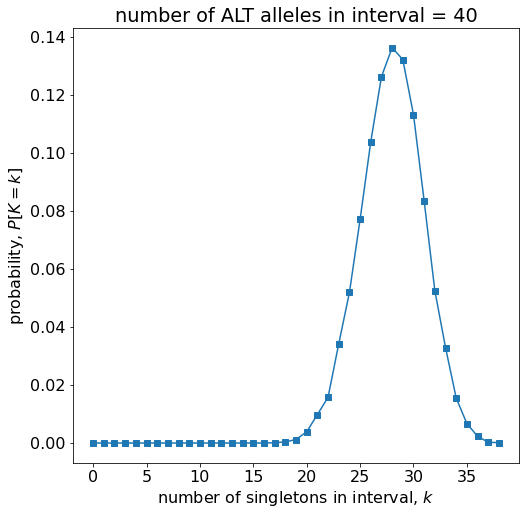

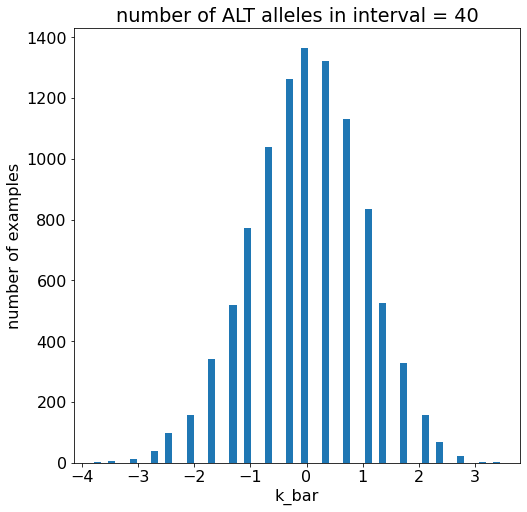

In [8]:
plot_K(m=40)


# Gauging the impact of allele frequency on calling natural selection

To gauge the impact of incorporating allele frequencies into a model that calls constraint, 
we may perform the following two experiments. 

In the first, we equate natural selecction with outliers in $\overline{N}$, and assess performance by producing, e.g., a ROC curve, using a 
positive control dataset. 

In the second, we use *both* $\overline{N}$ *and* $\overline{K}$ to make calls
by producing a two-dimensional scatter plot of these two test statistics
and searching for positive- and negative-selection outliers in the corresponding quadrants of the plot. 
There are countless ways to make calls, e.g., fitting a mixture of three gaussian distributions - 
one for the "inliers", one for the negative-selection "outliers", and one for the positive-selection "outliers". 
An example of this approach can be found [here](https://www.nature.com/articles/s41586-021-04043-8). 







# Training and validating the model

We adopted the following strategy for training the model, and making predictions genome-wide. 

We created a set of  trustworthy non-coding intervals by removing exons, sequencing gaps, and encode black-listed regions from the genome, and intersecting the resulting set of regions with a set of sites that are covered in a fraction XXX of individuals in gnomad version 3. We then split the resulting set of trustworthy non-coding regions into training and test subsets, putting regions on chromosomes 2, 4, 6, 8, 10-22, X and Y into the training set and regions on chromosomes 1, 3, 5, 7, 9 into the testing set. 

We trained the model on the training subset of trustworthy non-coding regions. We tested the model on the test subset of trustworthy non-coding regions by sweeping a window through the test set and computing z-scores for each window position. Additionally, we tested the model on the training subset. The result was a set of predictions for all trustworthy non-coding regions that was then used for discovery. 

We allayed concerns arising from the fact that predictions are made on the training set by showing (in a supporting figure) that results (e.g., fraction of significant-z-score windows that overlap known functional elements) are not statistically different between train and test subsets. This is similar to the strategy adopted by the authors of the splice-ai paper (see Fig S4 of the [paper](https://www.cell.com/cell/pdf/S0092-8674(18)31629-5.pdf)). 
